# Контекст

- Найти на изображении глазного яблока - глазной ямки (черное размытое пятно)
- размеры изображений разные
- 400 образцов всего
- метрика IOU / Пифагорово расстояние
- loss SmoothL1 

In [281]:
import pandas as pd
import numpy as np
import warnings
import random
import time
import copy

import torchvision
import seaborn as sns
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import matplotlib.patches as patches


import torch
from torch.utils.data import Dataset,\
                             DataLoader
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import ShuffleSplit


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings("ignore")
print('CUDA ?: ', torch.cuda.is_available())

CUDA ?:  True


# Чтение меток (позиции глазных ямок)

In [2]:
path2data = 'Training400/'
path2labels = path2data + 'DF_annotation/Training400/Fovea_location.xlsx'
labels = pd.read_excel(path2labels, index_col = 'ID')
labels.head()

imgName      Fovea_X      Fovea_Y
ID                                     
1   A0001.jpg  1182.264278  1022.018842
2   A0002.jpg   967.754046  1016.946655
3   A0003.jpg  1220.206714   989.944033
4   A0004.jpg  1141.140888  1000.594955
5   A0005.jpg  1127.371832  1071.109440

# Path ко всем изображениям

In [3]:
labels_AMD = [image for image in labels['imgName'] if image[0] == 'A']
labels_Non_AMD = [image for image in labels['imgName'] if image[0] == 'N']


path_to_AMD = 'Training400/AMD/'
path_to_Non_AMD = 'Training400/Non-AMD/'

all_labels_path = []
for base_path in labels['imgName']:
    if base_path[0] == 'A':
        all_labels_path.append(path_to_AMD + base_path)
    else:
        all_labels_path.append(path_to_Non_AMD + base_path)

all_labels_path[:5]

['Training400/AMD/A0001.jpg',
 'Training400/AMD/A0002.jpg',
 'Training400/AMD/A0003.jpg',
 'Training400/AMD/A0004.jpg',
 'Training400/AMD/A0005.jpg']

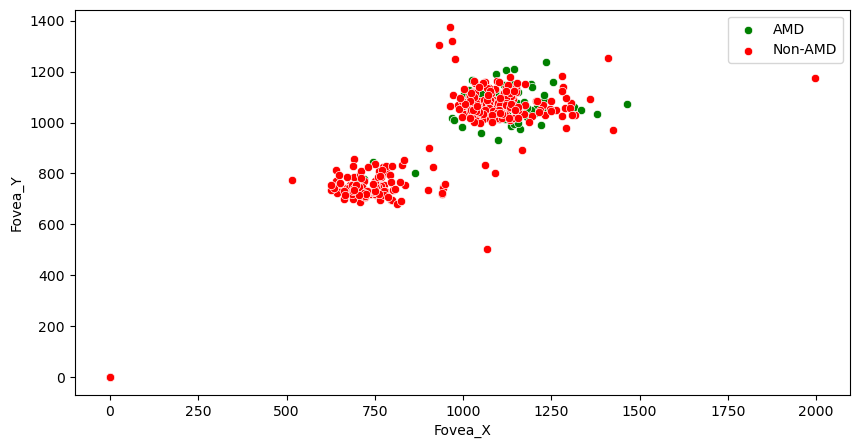

In [4]:
plt.figure(figsize = (10,5))

sns.scatterplot(
    data = labels[labels['imgName'].isin(labels_AMD)],
    x = 'Fovea_X',
    y = 'Fovea_Y',
    label = 'AMD',
    color = 'green'
)

sns.scatterplot(
    data = labels[labels['imgName'].isin(labels_Non_AMD)],
    x = 'Fovea_X',
    y = 'Fovea_Y',
    label = 'Non-AMD',
    color = 'red'
)
plt.legend()

# Рисуем изображение и метку

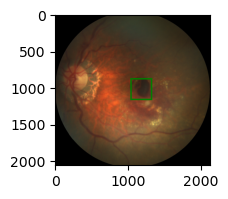

In [4]:
def plot_image_and_rectangle_by_path(img_full_path, w_h = (300, 300), width_green_rectangle = 20):
    image_base_path = img_full_path[-9:]
    img = Image.open(img_full_path)
    draw = ImageDraw.Draw(img)
    w,h = w_h
    x = labels[labels['imgName'] == image_base_path]['Fovea_X']
    y = labels[labels['imgName'] == image_base_path]['Fovea_Y']
    
    plt.figure(figsize = (2,2))
    draw.rectangle(
        ((x-w/2, y-h/2), (x+w/2, y+h/2)),
        outline = 'green',
        width = width_green_rectangle
        
                   )
    plt.imshow(np.asarray(img))

def plot_PIL_img(img, labels_set, w_h = (300, 300), width_green_rectangle = 20):
    
    draw = ImageDraw.Draw(img)
    w,h = w_h
    x , y = labels_set
    plt.figure(figsize = (2,2))
    draw.rectangle(
        ((x-w/2, y-h/2), (x+w/2, y+h/2)),
        outline = 'green',
        width = width_green_rectangle
                   )
    plt.imshow(np.asarray(img))



plot_image_and_rectangle_by_path(all_labels_path[0])


# Сохраняем все ширины и высоты изображений

In [5]:
h_list, w_list = [], [] 


for full_path in all_labels_path:
    img = Image.open(full_path)
    h, w = img.size
    h_list.append(h)
    w_list.append(w)

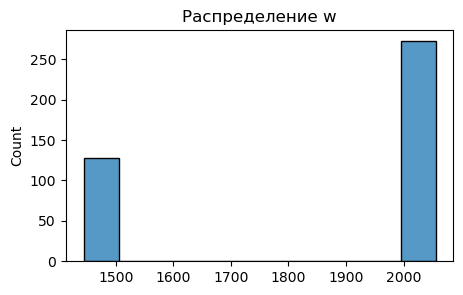

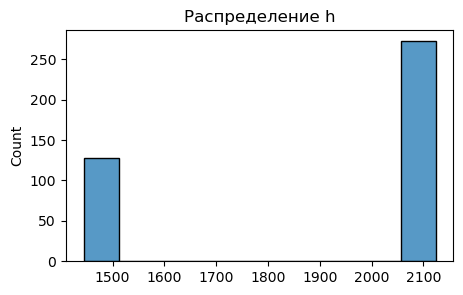

In [7]:
plt.figure(figsize = (5,3))
sns.histplot(w_list)
plt.title('Распределение w')
plt.show()

plt.figure(figsize = (5,3))
sns.histplot(h_list)
plt.title('Распределение h')
plt.show()

# Подготовка данных

- изменить размер всех изображений (до единого размера = 256*256)
- аугментация (зеркальные отображенияб повороты и тд.) из-за маленького количества изображений (400)
- если есть пункт аугментации, то и метки (координаты) надо обновить

## изменение размера и метки

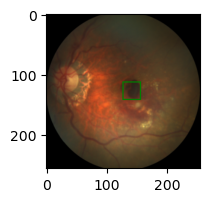

In [5]:
dataframe = pd.read_excel(path2labels, index_col = 'ID')

def resize_img_label(full_path_to_img, target_size = (256, 256)):

        image_base_path = full_path_to_img[-9:]
        img = Image.open(full_path_to_img)
        w_orig, h_orig = img.size
        w_target, h_target = target_size
        x = dataframe[dataframe['imgName'] == image_base_path]['Fovea_X'].item()
        y = dataframe[dataframe['imgName'] == image_base_path]['Fovea_Y'].item()

        image_new = TF.resize(img, (w_target, h_target))
        x_new = x/w_orig*w_target
        y_new = y/h_orig*w_target

        return image_new, (x_new, y_new)


new_imgage_A, labels_new_image_A = resize_img_label(all_labels_path[0])
plot_PIL_img(new_imgage_A,labels_new_image_A, (30,30), 2)

## Random hflip функция 

Flip демонстрация


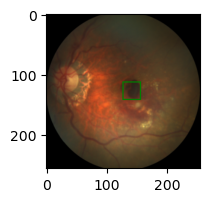

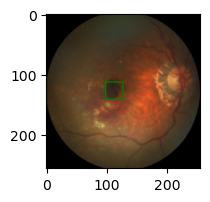

In [6]:
def random_hflip(image, label):
    w, h = image.size
    x , y = label

    image = TF.hflip(image)
    label = w-x, y
    return image, label


new_imgage_A, labels_new_image_A = resize_img_label(all_labels_path[0])
flip_new_image_A, flip_labels_new_image_A = random_hflip(new_imgage_A, labels_new_image_A)


print('Flip демонстрация')
plot_PIL_img(new_imgage_A, labels_new_image_A, (30,30), 2)
plot_PIL_img(flip_new_image_A, flip_labels_new_image_A, (30,30), 2)


## Random vflip функция  

Flip демонстрация


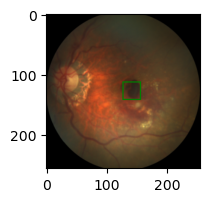

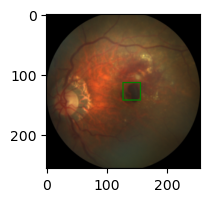

In [7]:
def random_vflip(image,label):
    w,h=image.size
    x,y=label
    image = TF.vflip(image)
    label = x, w-y
    return image, label

new_imgage_A, labels_new_image_A = resize_img_label(all_labels_path[0])
vflip_new_image_A, vflip_labels_new_image_A = random_vflip(new_imgage_A, labels_new_image_A)


print('Flip демонстрация')
plot_PIL_img(new_imgage_A, labels_new_image_A, (30,30), 2)
plot_PIL_img(vflip_new_image_A, vflip_labels_new_image_A, (30,30), 2)

## Random shift функция

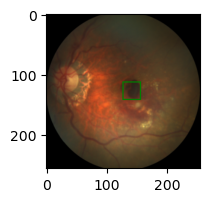

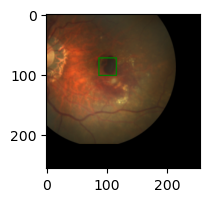

In [8]:
def random_shift(image, label, max_translate=(0.2, 0.2)):
    w,h = image.size
    max_t_w, max_t_h = max_translate
    cx, cy = label
    trans_coef = np.random.rand()*2-1
    w_t = int(trans_coef*max_t_w*w)
    h_t = int(trans_coef*max_t_h*h)

    image=TF.affine(
        image,
        translate = (w_t,h_t), # сдвиг вправо, сдвиг вниз
        shear = 0, # угол сдвига
        angle = 0, # угол поворота по часовой стрелке
        scale = 1 # масштабирование
        )
    
    label = cx + w_t, cy + h_t
    return image, label



new_imgage_A, labels_new_image_A = resize_img_label(all_labels_path[0])
affine_new_image_A, affine_labels_new_image_A = random_shift(new_imgage_A, labels_new_image_A)

plot_PIL_img(new_imgage_A, labels_new_image_A, (30,30), 2)
plot_PIL_img(affine_new_image_A, affine_labels_new_image_A, (30,30), 2)


## brightness функция изменения яркости

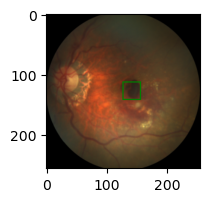

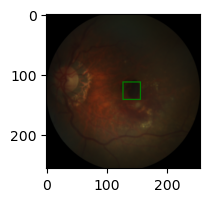

In [9]:
def brightness_change(img, label, brightness_factor = 0.5):
    img = TF.adjust_brightness(img, brightness_factor)
    return img, label


new_imgage_A, labels_new_image_A = resize_img_label(all_labels_path[0])
bright_new_image_A, bright_labels_new_image_A = brightness_change(new_imgage_A, labels_new_image_A)

plot_PIL_img(new_imgage_A, labels_new_image_A, (30,30), 2)
plot_PIL_img(bright_new_image_A, bright_labels_new_image_A, (30,30), 2)

## масштабирование метки до [0,1] и обратная функция

In [10]:
def scale_label(label_set, resize_image_size):
    '''  
    Масштабирование меток - деление меток на размер resize изображения. 
    '''
    w, h = resize_image_size
    x , y = label_set
    x_scaled =  x / w
    y_scaled = y / h
    return (x_scaled, y_scaled)


def rescale_label(label_set, image_size):
    '''  
    Обратное масштабирование меток
    '''
    w, h = image_size
    x , y = label_set
    x_scaled =  x*w
    y_scaled = y*h
    return (x_scaled, y_scaled)


## Объединение всех изменений в один трансформер, возвращающий тензор

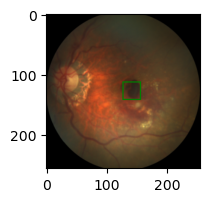

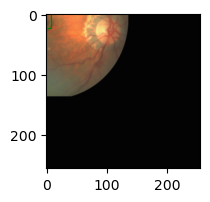

In [11]:
def transformer(full_path_image, params):
    ''' 
    возвращает тензор трасформированного изображения
    '''
    image, label = resize_img_label(full_path_image, params["target_size"])
    if random.random() < params["p_hflip"]:
        image, label = random_hflip(image, label)
    if random.random() < params["p_vflip"]:
        image, label = random_vflip(image, label)
    if random.random() < params["p_shift"]:
        image, label = random_shift(image, label, params["max_translate"])
    if random.random() < params["p_brightness"]:
        brightness_factor=1+(np.random.rand()*2-1)*params["brightness_factor"]
        image = TF.adjust_brightness(image,brightness_factor)
    if random.random() < params["p_contrast"]:
        contrast_factor=1+(np.random.rand()*2-1)*params["contrast_factor"]
        image=TF.adjust_contrast(image,contrast_factor)
    if random.random() < params["p_gamma"]:
        gamma=1+(np.random.rand()*2-1)*params["gamma"]
        image=TF.adjust_gamma(image,gamma)
    if params["scale_label"]:
        label = scale_label(label, params["target_size"])

    image = TF.to_tensor(image)
    return image, label



params = {

    "target_size" : (256, 256),
    "p_hflip" : 1.0,
    "p_vflip" : 1.0,
    "p_shift" : 1.0,
    "max_translate": (0.5, 0.5),
    "p_brightness": 1.0,
    "brightness_factor": 0.8,
    "p_contrast": 1.0,
    "contrast_factor": 0.8,
    "p_gamma": 1.0,
    "gamma": 0.4,
    "scale_label": False,
}

image_path_A = all_labels_path[0]
base_path = image_path_A[-9:]

new_imgage_A, labels_new_image_A = resize_img_label(image_path_A)
transforme_new_image_A, transforme_labels_new_image_A = transformer(image_path_A, params)

plot_PIL_img(new_imgage_A, labels_new_image_A, (30,30), 2)
plot_PIL_img(TF.to_pil_image(transforme_new_image_A), transforme_labels_new_image_A, (30,30), 2)

# Dataset

In [12]:
class EYE_Dataset(Dataset):
    
    def __init__(self, mode, transform_function, params_transform_dict):
        
        dataframe = pd.read_excel(path2labels, index_col = 'ID')
        self.data = dataframe.sample(frac = 1, ignore_index = True, random_state = 42)

        path_to_AMD = 'Training400/AMD/'
        path_to_Non_AMD = 'Training400/Non-AMD/'

        self.paths = []
        for base_path in self.data['imgName']:
            if base_path[0] == 'A':
                self.paths.append(path_to_AMD + base_path)
            else:
                self.paths.append(path_to_Non_AMD + base_path)


        train_size = int(len(self.data) * 0.8)
        if mode == 'train':
            self.frame = self.data[['Fovea_X', 'Fovea_Y']][:train_size].values
            self.paths = self.paths[:train_size]
        else:
            self.frame = self.data[['Fovea_X', 'Fovea_Y']][train_size:].values
            self.paths = self.paths[train_size:]

        self.transforme_function = transform_function
        self.params_dict = params_transform_dict

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):

        # image = Image.open(self.paths[index])
        label = self.frame[index]
        image , label = self.transforme_function(self.paths[index], self.params_dict)
        
        return image, label

In [13]:
transform_params_train = {

    "target_size" : (256, 256),
    "p_hflip" : 0.5,
    "p_vflip" : 0.5,
    "p_shift" : 0.5,
    "max_translate": (0.2, 0.2),
    "p_brightness": 0.5,
    "brightness_factor": 0.2,
    "p_contrast": 0.5,
    "contrast_factor": 0.2,
    "p_gamma": 0.5,
    "gamma": 0.2,
    "scale_label": True,

}


transform_params_val = {

    "target_size" : (256, 256),
    "p_hflip" : 0.0,
    "p_vflip" : 0.0,
    "p_shift" : 0.0,
    "p_brightness": 0.0,
    "p_contrast": 0.0,
    "p_gamma": 0.0,
    "gamma": 0.0,
    "scale_label": True

}

In [14]:
train_dataset = EYE_Dataset(
    mode = 'train',
    transform_function = transformer,
    params_transform_dict = transform_params_train
)

val_dataset = EYE_Dataset(
    mode = 'val',
    transform_function = transformer,
    params_transform_dict = transform_params_val
)

print(len(train_dataset), len(val_dataset))
print('________')
train_dataset[0][0].shape, train_dataset[0][1]  

320 80
________


(torch.Size([3, 256, 256]), (0.3228829790377213, 0.34186779155189695))

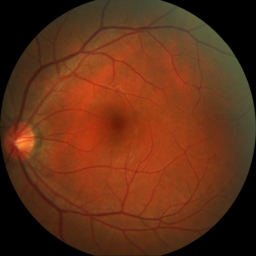

In [16]:
TF.to_pil_image(train_dataset[100][0])

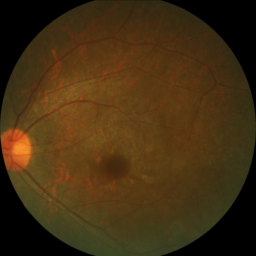

In [19]:
TF.to_pil_image(val_dataset[7][0])

# Dataloader

In [15]:
torch.manual_seed(42)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 8,
    shuffle = True
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 8,
    shuffle = False
)


# в тренировочном цикле метки, нужно будет стакнуть в нормальную матрицу и поменять dtype на float32:
for batch_img, batch_label in train_dataloader:
    batch_label = torch.stack(batch_label, dim = 1)
    print(batch_label)
    break

tensor([[0.5137, 0.5504],
        [0.5119, 0.5335],
        [0.4644, 0.4564],
        [0.4770, 0.5085],
        [0.4615, 0.5879],
        [0.6813, 0.6534],
        [0.6186, 0.4846],
        [0.5524, 0.5671]], dtype=torch.float64)


# Model

In [52]:
class Net(nn.Module):

    def __init__(self, params):
        super(Net, self).__init__()


        C_in, H_in, W_in = params['input_shape']
        num_filters = params['initial_filters']
        num_outputs = params['num_outputs']

        self.conv1 = nn.Conv2d(
            in_channels = C_in,
            out_channels = num_filters,
            kernel_size = 3,
            stride = 2,
            padding = 1
        )

        self.conv2 = nn.Conv2d(
            in_channels = num_filters + C_in, # техника ResNet 
            out_channels = num_filters*2,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
    
        self.conv3 = nn.Conv2d(
            num_filters*3 + C_in,
            
            num_filters*4,
            kernel_size = 3,
            stride = 1,
            padding = 1
            )
        
        self.conv4 = nn.Conv2d(
            num_filters*7 + C_in,
            num_filters*8,
            kernel_size = 3,
            stride = 1,
            padding = 1
            )
        
        self.conv5 = nn.Conv2d(
            num_filters*15 + C_in,
            num_filters*16,
            kernel_size = 3,
            stride = 1,
            padding = 1
            )
        
        self.linear = nn.Linear(16*num_filters, num_outputs)

    
    def forward(self, x):

        # x.shape = 8*3*256*256
        identify = F.avg_pool2d(x, 4,4) # 8*3*64*64
        x = F.relu(self.conv1(x)) # 8*16*128*128 (изменится размер изображения 256*256 --> 128*128 из-за stride = 2)
        x = F.max_pool2d(x, 2, 2) # 8*16*128*128
        x = torch.cat((x , identify), dim = 1) # 8*19*64*64 (конкатенация по dim = 1 (по канальному измерению))

        identify = F.avg_pool2d(x, 2, 2) # 8*19*32*32
        x = F.relu(self.conv2(x)) # 8*32*64*64
        x = F.max_pool2d(x, 2, 2) # 8*32*32*32
        x = torch.cat((x, identify), dim = 1) # 8*51*32*32

        identify = F.avg_pool2d(x, 2, 2) # 8*51*16*16
        x = F.relu(self.conv3(x)) # 8*64*32*32
        x = F.max_pool2d(x, 2, 2) # 8*64*16*16
        x = torch.cat((x, identify), dim = 1) # 8*115*16*16

        identify = F.avg_pool2d(x, 2, 2) # 8*115*8*8
        x = F.relu(self.conv4(x)) # 8*128*16*16
        x = F.max_pool2d(x, 2, 2) # 8*128*8*8
        x = torch.cat((x, identify), dim = 1) # 8*243*8*8

        x = F.relu(self.conv5(x)) # 8*256*8*8
        x = F.adaptive_avg_pool2d(x, 1) # 8*256*1*1
        x = x.reshape(x.size(0), -1) # 8*256

        x = self.linear(x) # по сути задача регрессии (прогнозирование координат)
        return x
        

params = {

    'input_shape': (3,256,256),
    'initial_filters': 16,
    'num_outputs': 2 # две координаты центра глазной ямки x, y

}

# Training loop

## IOU metric function

### Главные координаты бокса (функция нахождения x_min, y_min, x_max, y_max)

In [15]:
def cxcy2bbox(cxcy,w =20./256,h = 20./256): # деление на 256 из-за масштабирования координат
    w_tensor=torch.ones(cxcy.shape[0],1,device=cxcy.device)*w
    h_tensor=torch.ones(cxcy.shape[0],1,device=cxcy.device)*h
    cx=cxcy[:,0].unsqueeze(1)
    cy=cxcy[:,1].unsqueeze(1)
    boxes=torch.cat((cx, cy, w_tensor, h_tensor), -1) # cx,cy,w,h

    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2, # xmin, ymin
                      boxes[:, :2] + boxes[:, 2:]/2), 1) # xmax, ymax

### IOU функция

In [16]:
def metric_batch(output, target):
    output = cxcy2bbox(output)
    target = cxcy2bbox(target)
    iou = torchvision.ops.box_iou(output, target)
    return torch.diagonal(iou, 0).sum().item()

# L1 / L2 регуляризация (функция)

In [17]:
def loss_with_l1_or_l2_regulizer(
        
        model,
        type, # Здесь могут быть 3 вида : 'l1', 'l2', 'l1_l2' 
        l_lambda, # 0.001
        loss_by_fn):
    
    if type == 'l2':
        l_norm = sum(p.pow(2.0).sum() for p in model.parameters())

    if type == 'l1':
        l_norm = sum(p.abs().sum() for p in model.parameters())

    if type == 'l1_l2':
        l_norm = sum((p.abs() + p.pow(2.0)).sum() for p in model.parameters())
    
    loss_plus_reg = loss_by_fn + l_lambda * l_norm
    return loss_plus_reg



def create_folder(name):
    import os
    os.mkdir(name)

In [31]:
def training_loop(
        # папка сохранения
        name_model_folder,


        # основные настройки
        epoches,
        model,
        optimizer,

        # контроль скорости
        scheduler_append,
        scheduler,
        step_on, # str 'val_loss', 'train_loss'

        loss_fn,
        train_dataloader,
        val_dataloader,

        # regulizer
        regulizer_append,
        reg_type,
        
        # stop settings
        stop_mode,
        each__X__epoch,
        min_delta,
        patience,

        # verbose
        verbose_epoch
        ):
    
    
    create_folder(name_model_folder)
    
    loss_train_list = []
    loss_val_list = []
    IOU_train_list__book = []
    IOU_val_list__book = []
    best_loss = float('inf')
    patience_beginner = patience

    model = model.to(device)

    for epoch in range(1, epoches+1):
            
            start_time = time.time()

            loss_train = 0.0
            loss_val = 0.0
            IOU_train_epoch_sum___book = 0.0
            IOU_val_epoch_sum___book = 0.0

            for features, labels in train_dataloader:
                
                model.train()
                features = features.to(device)
                labels = torch.cat((labels[0].reshape(-1,1), labels[1].reshape(-1,1)), dim = 1)
                labels = labels.to(device)
                outputs = model(features)

                # Тренировочный потери
                loss = loss_fn(outputs, labels)
                
                if regulizer_append:
                        loss = loss_with_l1_or_l2_regulizer(
                                model = model,
                                type = reg_type,
                                l_lambda = 0.001,
                                loss_by_fn = loss
                                )
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_train += loss.item()

                IOU_train_epoch_sum___book += metric_batch(outputs, labels)
                

            mean_epoch_loss_train = loss_train/len(train_dataloader)
            loss_train_list.append(mean_epoch_loss_train)
            ######## Расчет метрики на тренировочном наборе #####
            IOU_train_epoch__book = IOU_train_epoch_sum___book / len(train_dataloader.dataset)
            IOU_train_list__book.append(IOU_train_epoch__book)
            #####################################################
            # Проверочный этап
            model.eval()
            with torch.no_grad():
                for features, labels in val_dataloader:
                        features = features.to(device)
                        labels = torch.cat((labels[0].reshape(-1,1), labels[1].reshape(-1,1)), dim = 1)
                        labels = labels.to(device)
                        outputs = model(features)
                        loss_on_val = loss_fn(outputs, labels)
                        loss_val += loss_on_val.item()

                        IOU_val_epoch_sum___book += metric_batch(outputs, labels)

                mean_epoch_loss_val = loss_val / len(val_dataloader)
                loss_val_list.append(mean_epoch_loss_val)

                ######## Расчет метрики на валидационном наборе #####
                IOU_val_epoch__book = IOU_val_epoch_sum___book / len(val_dataloader.dataset)
                IOU_val_list__book.append(IOU_val_epoch__book)
                ######################################################
                
            # EARLY STOPPING #######################################
            if stop_mode:
                if epoch % each__X__epoch == 0:
                        current_loss = mean_epoch_loss_train
                        if current_loss < best_loss - min_delta:
                                best_loss = current_loss
                                patience = patience_beginner
                        else:
                                patience -= 1
                                if patience == 0:
                                        print(f"Ранняя тренировочная остановка на {epoch} эпохе")
                                        break
            ##############################################################
            # Сохранение состояний модели
            if mean_epoch_loss_val < best_loss:
                    best_loss = mean_epoch_loss_val
                    torch.save(model.state_dict(), f'{name_model_folder}/model_weights_{epoch}_epoch.pth')
            # Контроль скорости обучения
            if scheduler_append:
                if step_on == 'val_loss':
                        scheduler.step(mean_epoch_loss_val)
                if step_on == 'train_loss':
                        scheduler.step(mean_epoch_loss_train)
            ##############################################################
            end_time = time.time()
            epoch_time = end_time - start_time
            расчетное_время_выполнения_цикла = (epoch_time*epoches) / 60
            ############ VERBOSE #########################################
            if epoch ==1:
                   print('Расчетное время выполнения всего цикла {:.3f} минут'.format(расчетное_время_выполнения_цикла))            
            if epoch == 1 or epoch % verbose_epoch == 0:
                print(
                        'Epoch {:5}/{:5} || time: {:.3f} || train loss: {:.3f} || val_loss: {:.3f} || train IOU: {:.3f} || val IOU: {:.3f}'
                        .format(epoch,
                                epoches,
                                epoch_time,
                                mean_epoch_loss_train,
                                mean_epoch_loss_val,
                                IOU_train_epoch__book,
                                IOU_val_epoch__book,
                                )     
                      )
    ###### PLOTTING #############################################################################
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_train_list,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_val_list,
                 label = 'val')
    plt.title('Потери от эпох')
    plt.xlabel('эпохи')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

    sns.lineplot(x = np.arange(1, epoch+1),
                 y = IOU_train_list__book,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = IOU_val_list__book,
                 label = 'val')
    
    plt.xlabel('эпохи')
    plt.ylabel('accuracy')
    plt.title('accuracy on train: {}   lr: {}'.format(epoches,
                                                      optimizer.param_groups[0]['lr']))
    plt.legend()
    plt.grid()
    plt.show()

# model_1

Расчетное время выполнения всего цикла 30.473 минут
Epoch     1/  100 || time: 18.284 || train loss: 0.270 || val_loss: 0.090 || train IOU: 0.056 || val IOU: 0.172
Epoch    10/  100 || time: 17.661 || train loss: 0.047 || val_loss: 0.072 || train IOU: 0.188 || val IOU: 0.195
Epoch    20/  100 || time: 17.943 || train loss: 0.048 || val_loss: 0.074 || train IOU: 0.164 || val IOU: 0.206
Epoch    30/  100 || time: 17.464 || train loss: 0.041 || val_loss: 0.064 || train IOU: 0.229 || val IOU: 0.357
Epoch    40/  100 || time: 18.735 || train loss: 0.038 || val_loss: 0.064 || train IOU: 0.264 || val IOU: 0.342
Epoch    50/  100 || time: 18.781 || train loss: 0.039 || val_loss: 0.071 || train IOU: 0.233 || val IOU: 0.155
Epoch    60/  100 || time: 19.149 || train loss: 0.036 || val_loss: 0.067 || train IOU: 0.248 || val IOU: 0.211
Epoch    70/  100 || time: 18.816 || train loss: 0.035 || val_loss: 0.064 || train IOU: 0.278 || val IOU: 0.367
Epoch    80/  100 || time: 18.807 || train loss: 0.0

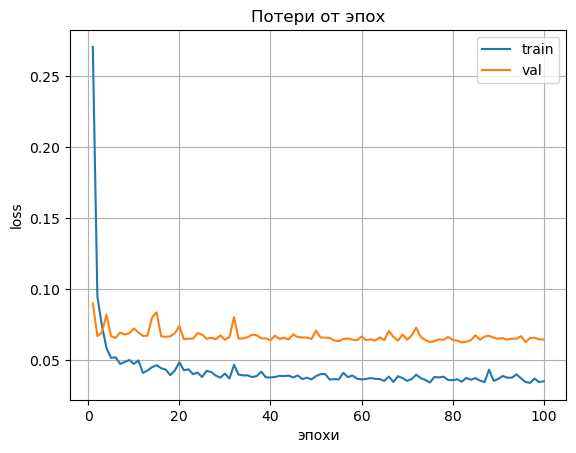

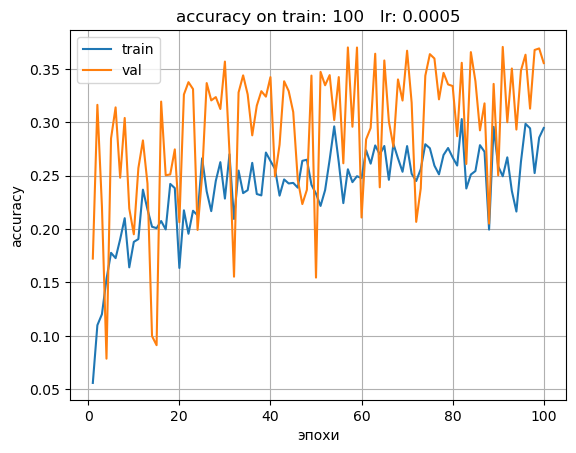

In [34]:
model = Net(params)

loss_fn = nn.SmoothL1Loss(reduction = 'sum')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

train_dataloader = DataLoader(
    dataset = EYE_Dataset(mode = 'train',
                          transform_function = transformer,
                          params_transform_dict = transform_params_train),
    batch_size = 8,
    shuffle = False
)


val_dataloader = DataLoader(
    dataset = EYE_Dataset(mode = 'val',
                          transform_function = transformer,
                          params_transform_dict = transform_params_val),
    batch_size = 8,
    shuffle = False
)


training_loop(

    name_model_folder = 'model_1',
    epoches = 100,
    model = model,
    optimizer = optimizer,
    scheduler_append = False,
    scheduler = None,
    step_on = None,
    loss_fn = loss_fn,
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer_append = False,
    reg_type = None,
    stop_mode = True,
    each__X__epoch = 20,
    min_delta = 0.0001,
    patience = 10,
    verbose_epoch = 10

)

# model_2

# pifagor

In [57]:
def pifagorovo_rasstoyanie(predict_labels, real_labels, image_size = (256,256)):

    x_target = real_labels[:,0]*image_size[0]
    y_target = real_labels[:,1]*image_size[1]
    x_predict = predict_labels[:,0]*image_size[0]
    y_predict = predict_labels[:,1]*image_size[1]

    r = torch.sqrt(((x_target - x_predict)**2) + ((y_target - y_predict)**2))
    return r.sum().item()

# training loop new

In [135]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [137]:
def training_loop(
        # папка сохранения
        name_model_folder,

        # основные настройки
        epoches,
        model,
        optimizer,
        metric_str,

        # контроль скорости
        scheduler_append,
        scheduler,
        step_on, # str 'val_loss', 'train_loss'

        loss_fn,
        train_dataloader,
        val_dataloader,

        # regulizer
        regulizer_append,
        reg_type,
        
        # stop settings
        stop_mode,
        each__X__epoch,
        min_delta,
        patience,

        # verbose
        verbose_epoch
        ):
    
    
    create_folder(name_model_folder)
    
    loss_history = {
           'train_loss': [],
           'val_loss': []
    }

    metric_history = {
           'train_metric': [],
           'val_metric': []
    }

    best_loss = float('inf')
    patience_beginner = patience
    model = model.to(device)

    for epoch in range(1, epoches+1):
            
            start_time = time.time()
            model.train()
            current_lr = get_lr(optimizer)
            loss_train = 0.0
            loss_val = 0.0
            train_summarize_metric = 0.0
            val_summarize_metric = 0.0

            for features, labels in train_dataloader:
                
                optimizer.zero_grad()

                features = features.to(device)
                labels = torch.cat((labels[0].reshape(-1,1), labels[1].reshape(-1,1)), dim = 1)
                labels = torch.tensor(labels, dtype = torch.float32)
                labels = labels.to(device)
                outputs = model(features)

                # Тренировочный потери
                loss = loss_fn(outputs, labels)
                
                if regulizer_append:
                        loss = loss_with_l1_or_l2_regulizer(
                                model = model,
                                type = reg_type,
                                l_lambda = 0.001,
                                loss_by_fn = loss
                                )
                

                loss.backward()
                optimizer.step()
                
                loss_train += loss.item()

                train_summarize_metric += pifagorovo_rasstoyanie(outputs, labels)
                

            train_mean_epoch_loss = loss_train/len(train_dataloader)
            loss_history['train_loss'].append(train_mean_epoch_loss)
            ######## Расчет метрики на тренировочном наборе #####
            train_mean_epoch_metric = train_summarize_metric / len(train_dataloader.dataset) # !!!!!
            metric_history['train_metric'].append(train_mean_epoch_metric)
            #####################################################
            # Проверочный этап
            model.eval()
            with torch.no_grad():
                for features, labels in val_dataloader:
                        features = features.to(device)
                        labels = torch.cat((labels[0].reshape(-1,1), labels[1].reshape(-1,1)), dim = 1)
                        labels = torch.tensor(labels, dtype = torch.float32)
                        labels = labels.to(device)
                        outputs = model(features)
                        loss_on_val = loss_fn(outputs, labels)
                        loss_val += loss_on_val.item()

                        val_summarize_metric += pifagorovo_rasstoyanie(outputs, labels)

                val_mean_epoch_loss = loss_val / len(val_dataloader)
                loss_history['val_loss'].append(val_mean_epoch_loss)

                ######## Расчет метрики на валидационном наборе #####
                val_mean_epoch_metric = val_summarize_metric / len(val_dataloader.dataset)
                metric_history['val_metric'].append(val_mean_epoch_metric)
                ######################################################
                
            # EARLY STOPPING #######################################
            if stop_mode:
                if epoch % each__X__epoch == 0:
                        current_loss = train_mean_epoch_loss
                        if current_loss < best_loss - min_delta:
                                best_loss = current_loss
                                patience = patience_beginner
                        else:
                                patience -= 1
                                if patience == 0:
                                        print(f"Ранняя тренировочная остановка на {epoch} эпохе")
                                        break
            ##############################################################
            # Сохранение состояний модели
            if val_mean_epoch_loss < best_loss:
                    best_loss = val_mean_epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f'{name_model_folder}/model_weights_{epoch}_epoch.pth')
            # Контроль скорости обучения
            if scheduler_append:
                if step_on == 'val_loss':
                        scheduler.step(val_mean_epoch_loss)
                if step_on == 'train_loss':
                        scheduler.step(train_mean_epoch_loss)
            # загрузка текущих лучших весов модели 
            if current_lr != get_lr(optimizer):
                   model.load_state_dict(best_model_wts)
            ##############################################################
            end_time = time.time()
            epoch_time = end_time - start_time
            ############ VERBOSE #########################################
            if epoch ==1:
                   расчетное_время_выполнения_цикла = (epoch_time*epoches) / 60
                   print('Расчетное время выполнения всего цикла {:.3f} минут'.format(расчетное_время_выполнения_цикла))            
            if epoch == 1 or epoch % verbose_epoch == 0:
                print(
                        'Epoch {:5}/{:5} || time: {:.3f} || train loss: {:.3f} || val_loss: {:.3f} || train metric: {:.3f} || val metric: {:.3f}'\
                        .format(epoch,
                                epoches,
                                epoch_time,
                                train_mean_epoch_loss,
                                val_mean_epoch_loss,
                                train_mean_epoch_metric,
                                val_mean_epoch_metric,
                                )     
                      )
    ###### PLOTTING #############################################################################
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_history['train_loss'],
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_history['val_loss'],
                 label = 'val')
    plt.title('Потери от эпох')
    plt.xlabel('эпохи')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

    sns.lineplot(x = np.arange(1, epoch+1),
                 y = metric_history['train_metric'],
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = metric_history['val_metric'],
                 label = 'val')
    
    plt.xlabel('эпохи')
    plt.ylabel(f'{metric_str}')
    plt.title('{} on train: {}   lr: {}'.format(metric_str,
                                                epoches,
                                                optimizer.param_groups[0]['lr']))
    plt.legend()
    plt.grid()
    plt.show()

    return model, loss_history, metric_history

In [49]:
class Net(nn.Module):

    def __init__(self, params):
        super(Net, self).__init__()


        C_in, H_in, W_in = params['input_shape']
        num_filters = params['initial_filters']
        num_outputs = params['num_outputs']

        self.conv1 = nn.Conv2d(
            in_channels = C_in,
            out_channels = num_filters,
            kernel_size = 3,
            stride = 2,
            padding = 1
        )

        self.conv2 = nn.Conv2d(
            in_channels = num_filters + C_in, # техника ResNet 
            out_channels = num_filters*2,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
    
        self.conv3 = nn.Conv2d(
            num_filters*3 + C_in,
            num_filters*4,
            kernel_size = 3,
            stride = 1,
            padding = 1
            )
        
        self.conv4 = nn.Conv2d(
            num_filters*7 + C_in,
            num_filters*8,
            kernel_size = 3,
            stride = 1,
            padding = 1
            )
        
        self.conv5 = nn.Conv2d(
            num_filters*15 + C_in,
            num_filters*16,
            kernel_size = 3,
            stride = 1,
            padding = 1
            )
        
        self.linear = nn.Linear(num_filters*16, num_outputs)

    
    def forward(self, x):

        # x.shape = 8*3*256*256
        identify = F.avg_pool2d(x, 4,4) # 8*3*64*64
        x = F.relu(self.conv1(x)) # 8*16*128*128 (изменится размер изображения 256*256 --> 128*128 из-за stride = 2)
        x = F.max_pool2d(x, 2, 2) # 8*16*128*128
        x = torch.dropout(x , p = 0.4)
        x = torch.cat((x , identify), dim = 1) # 8*19*64*64 (конкатенация по dim = 1 (по канальному измерению))

        identify = F.avg_pool2d(x, 2, 2) # 8*19*32*32
        x = F.relu(self.conv2(x)) # 8*32*64*64
        x = F.max_pool2d(x, 2, 2) # 8*32*32*32
        x = torch.dropout(x , p = 0.4)
        x = torch.cat((x, identify), dim = 1) # 8*51*32*32

        identify = F.avg_pool2d(x, 2, 2) # 8*51*16*16
        x = F.relu(self.conv3(x)) # 8*64*32*32
        x = F.max_pool2d(x, 2, 2) # 8*64*16*16
        x = torch.dropout(x , p = 0.4)
        x = torch.cat((x, identify), dim = 1) # 8*115*16*16

        identify = F.avg_pool2d(x, 2, 2) # 8*115*8*8
        x = F.relu(self.conv4(x)) # 8*128*16*16
        x = F.max_pool2d(x, 2, 2) # 8*128*8*8
        x = torch.dropout(x , p = 0.4)
        x = torch.cat((x, identify), dim = 1) # 8*243*8*8

        x = F.relu(self.conv5(x)) # 8*256*8*8
        x = F.adaptive_avg_pool2d(x, 1) 
        x = x.reshape(x.size(0), -1)

        x = self.linear(x) # по сути задача регрессии (прогнозирование координат)
        return x
        

params = {

    'input_shape': (3,256,256),
    'initial_filters': 16,
    'num_outputs': 2 # две координаты центра глазной ямки x, y

}

Расчетное время выполнения всего цикла 31.732 минут
Epoch     1/  100 || time: 19.039 || train loss: 0.178 || val_loss: 0.078 || train metric: 38.053 || val metric: 24.936
Epoch    10/  100 || time: 18.888 || train loss: 0.083 || val_loss: 0.066 || train metric: 27.323 || val metric: 16.176
Epoch    20/  100 || time: 18.569 || train loss: 0.044 || val_loss: 0.062 || train metric: 17.236 || val metric: 16.421
Epoch    30/  100 || time: 19.179 || train loss: 0.038 || val_loss: 0.059 || train metric: 16.035 || val metric: 15.038
Epoch    40/  100 || time: 18.990 || train loss: 0.039 || val_loss: 0.061 || train metric: 15.904 || val metric: 17.143
Epoch    50/  100 || time: 19.067 || train loss: 0.038 || val_loss: 0.060 || train metric: 14.947 || val metric: 14.833
Epoch    60/  100 || time: 18.144 || train loss: 0.038 || val_loss: 0.061 || train metric: 15.378 || val metric: 16.687
Epoch    70/  100 || time: 18.732 || train loss: 0.036 || val_loss: 0.060 || train metric: 14.662 || val met

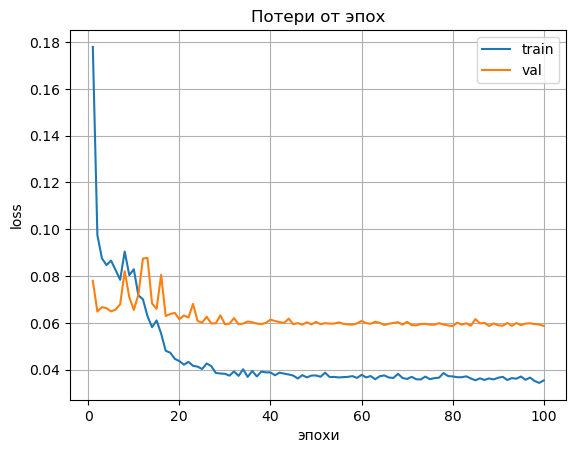

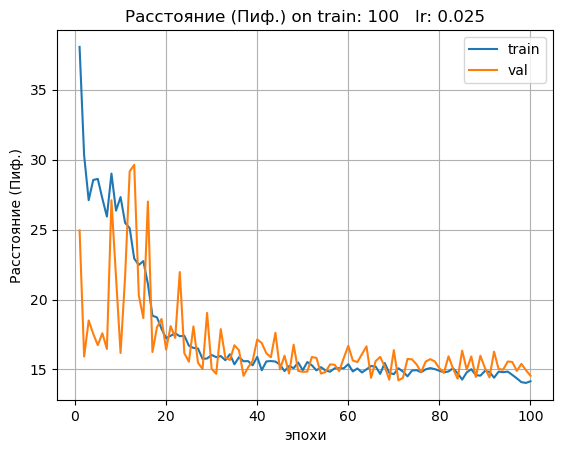

In [42]:
model = Net(params)

loss_fn = nn.SmoothL1Loss(reduction = 'sum')
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience = 15,verbose=1)

train_dataloader = DataLoader(
    dataset = EYE_Dataset(mode = 'train',
                          transform_function = transformer,
                          params_transform_dict = transform_params_train),
    batch_size = 8,
    shuffle = False
)


val_dataloader = DataLoader(
    dataset = EYE_Dataset(mode = 'val',
                          transform_function = transformer,
                          params_transform_dict = transform_params_val),
    batch_size = 8,
    shuffle = False
)


training_loop(

    name_model_folder = 'model_8',
    epoches = 100,
    model = model,
    optimizer = optimizer,
    metric_str = 'Расстояние (Пиф.)',
    scheduler_append = True,
    scheduler = scheduler,
    step_on = 'val_loss',
    loss_fn = loss_fn,
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer_append = False,
    reg_type = None,
    stop_mode = True,
    each__X__epoch = 10,
    min_delta = 0.0001,
    patience = 7, 
    verbose_epoch = 10

)

# model_3

In [ ]:
model = Net(params)

loss_fn = nn.SmoothL1Loss(reduction = 'sum')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience = 15,verbose=1)

train_dataloader = DataLoader(
    dataset = EYE_Dataset(mode = 'train',
                          transform_function = transformer,
                          params_transform_dict = transform_params_train),
    batch_size = 8,
    shuffle = False
)


val_dataloader = DataLoader(
    dataset = EYE_Dataset(mode = 'val',
                          transform_function = transformer,
                          params_transform_dict = transform_params_val),
    batch_size = 8,
    shuffle = False
)


training_loop(

    name_model_folder = 'model_3',
    epoches = 100,
    model = model,
    optimizer = optimizer,
    metric_str = 'Расстояние (Пиф.)',
    scheduler_append = True,
    scheduler = scheduler,
    step_on = 'val_loss',
    loss_fn = loss_fn,
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer_append = False,
    reg_type = None,
    stop_mode = True,
    each__X__epoch = 10,
    min_delta = 0.0001,
    patience = 7, 
    verbose_epoch = 10

)


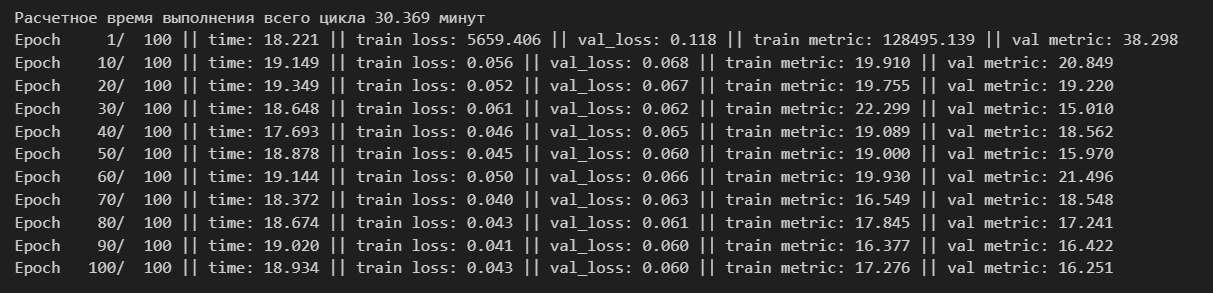

# model_4

In [110]:
class Net(nn.Module):

    def __init__(self, params):
        super(Net, self).__init__()


        C_in, H_in, W_in = params['input_shape']
        num_filters = params['initial_filters']
        num_outputs = params['num_outputs']

        self.conv1 = nn.Conv2d(
            in_channels = C_in,
            out_channels = num_filters,
            kernel_size = 3,
            stride = 2,
            padding = 1
        )

        self.conv2 = nn.Conv2d(
            in_channels = num_filters + C_in, # техника ResNet 
            out_channels = num_filters*2,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
    
        self.conv3 = nn.Conv2d(
            num_filters*3 + C_in,
            num_filters*4,
            kernel_size = 3,
            stride = 1,
            padding = 1
            )
        
        self.conv4 = nn.Conv2d(
            num_filters*7 + C_in,
            num_filters*8,
            kernel_size = 3,
            stride = 1,
            padding = 1
            )
        
        self.conv5 = nn.Conv2d(
            num_filters*15 + C_in,
            num_filters*16,
            kernel_size = 3,
            stride = 1,
            padding = 1
            )
        
        self.linear = nn.Linear(num_filters*16, num_outputs)

    
    def forward(self, x):

        # x.shape = 8*3*256*256
        identify = F.avg_pool2d(x, 4,4) # 8*3*64*64
        x = F.relu(self.conv1(x)) # 8*16*128*128 (изменится размер изображения 256*256 --> 128*128 из-за stride = 2)
        x = F.max_pool2d(x, 2, 2) # 8*16*128*128
        x = torch.dropout(x , p = 0.4, train = True)
        x = torch.cat((x , identify), dim = 1) # 8*19*64*64 (конкатенация по dim = 1 (по канальному измерению))

        identify = F.avg_pool2d(x, 2, 2) # 8*19*32*32
        x = F.relu(self.conv2(x)) # 8*32*64*64
        x = F.max_pool2d(x, 2, 2) # 8*32*32*32
        x = torch.dropout(x , p = 0.4, train = True)
        x = torch.cat((x, identify), dim = 1) # 8*51*32*32

        identify = F.avg_pool2d(x, 2, 2) # 8*51*16*16
        x = F.relu(self.conv3(x)) # 8*64*32*32
        x = F.max_pool2d(x, 2, 2) # 8*64*16*16
        x = torch.dropout(x , p = 0.4, train = True)
        x = torch.cat((x, identify), dim = 1) # 8*115*16*16

        identify = F.avg_pool2d(x, 2, 2) # 8*115*8*8
        x = F.relu(self.conv4(x)) # 8*128*16*16
        x = F.max_pool2d(x, 2, 2) # 8*128*8*8
        x = torch.dropout(x , p = 0.4, train = True)
        x = torch.cat((x, identify), dim = 1) # 8*243*8*8

        x = F.relu(self.conv5(x)) # 8*256*8*8
        x = F.adaptive_avg_pool2d(x, 1) 
        x = x.reshape(x.size(0), -1)

        x = self.linear(x) # по сути задача регрессии (прогнозирование координат)
        return x
        

params = {

    'input_shape': (3,256,256),
    'initial_filters': 16,
    'num_outputs': 2 # две координаты центра глазной ямки x, y

}

In [42]:
class EYE_Dataset_update(Dataset):
    
    def __init__(self, mode, transform_function, params_transform_dict):
        
        dataframe = pd.read_excel(path2labels, index_col = 'ID')
        self.data = dataframe.sample(frac = 1, ignore_index = True, random_state = 42)

        path_to_AMD = 'Training400/AMD/'
        path_to_Non_AMD = 'Training400/Non-AMD/'

        self.paths = []
        for base_path in self.data['imgName']:
            if base_path[0] == 'A':
                self.paths.append(path_to_AMD + base_path)
            else:
                self.paths.append(path_to_Non_AMD + base_path)

        self.data['path'] = self.paths
        train_size = int(len(self.data) * 0.8)

        if mode == 'train':
            self.data = self.data[:train_size]
            self.data = pd.concat([self.data]*5, ignore_index = True)
            self.frame = self.data[['Fovea_X', 'Fovea_Y']].values
            self.paths = self.data['path'].values
            print('Размер тренировочного сета: {}'.format(len(self.frame)))
        else:
            self.frame = self.data[['Fovea_X', 'Fovea_Y']][train_size:].values
            self.paths = self.paths[train_size:]
            print('Размер валидационного сета: {}'.format(len(self.frame)))

        self.transforme_function = transform_function
        self.params_dict = params_transform_dict


    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        # image = Image.open(self.paths[index])
        label = self.frame[index]
        image , label = self.transforme_function(self.paths[index], self.params_dict)
        return image, label

Расчетное время выполнения всего цикла 30.025 минут
Epoch     1/  100 || time: 18.015 || train loss: 1355814.156 || val_loss: 4169.191 || train metric: 1535890.746 || val metric: 9665.729
Epoch     2/  100 || time: 18.000 || train loss: 6730.933 || val_loss: 16.152 || train metric: 7824.549 || val metric: 160.932
Epoch     3/  100 || time: 18.000 || train loss: 29.205 || val_loss: 3.160 || train metric: 150.372 || val metric: 69.851
Epoch     4/  100 || time: 18.643 || train loss: 7.655 || val_loss: 14.573 || train metric: 71.246 || val metric: 138.854
Epoch     5/  100 || time: 17.722 || train loss: 25.019 || val_loss: 11.420 || train metric: 121.374 || val metric: 135.278
Epoch     6/  100 || time: 17.957 || train loss: 21.697 || val_loss: 2.677 || train metric: 129.261 || val metric: 61.483
Epoch     7/  100 || time: 17.273 || train loss: 4.621 || val_loss: 1.146 || train metric: 51.380 || val metric: 33.813
Epoch     8/  100 || time: 17.350 || train loss: 3.438 || val_loss: 1.216 |

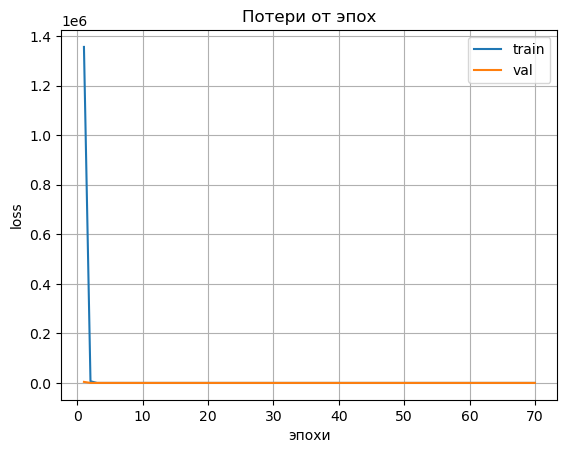

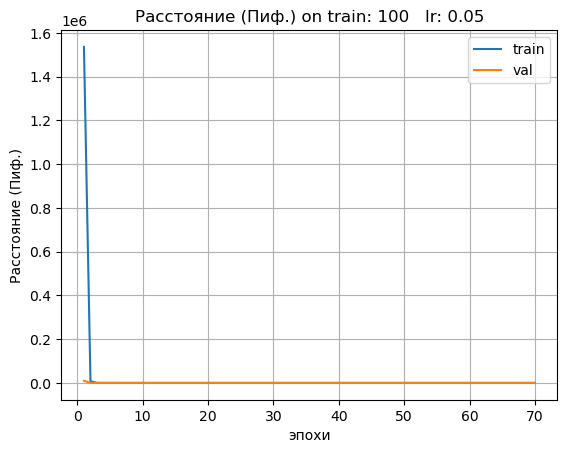

In [65]:
model = Net(params)

loss_fn = nn.SmoothL1Loss(reduction = 'sum')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min',factor = 0.5, patience = 15, verbose = 1)

train_dataloader = DataLoader(
    dataset = EYE_Dataset(
        mode = 'train',
        transform_function = transformer,
        params_transform_dict = transform_params_train),
    batch_size = 256,
    shuffle = False
)


val_dataloader = DataLoader(
    dataset = EYE_Dataset(
        mode = 'val',
        transform_function = transformer,
        params_transform_dict = transform_params_val),
    batch_size = 256,
    shuffle = False
)


model, loss_history, metric_history = training_loop(

    name_model_folder = 'model_4',
    epoches = 100,
    model = model,
    optimizer = optimizer,
    metric_str = 'Расстояние (Пиф.)',
    scheduler_append = False,
    scheduler = scheduler,
    step_on = 'val_loss',
    loss_fn = loss_fn,
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer_append = False,
    reg_type = None,
    stop_mode = True,
    each__X__epoch = 10,
    min_delta = 0.0001,
    patience = 7, 
    verbose_epoch = 1

)


# model_5

## Dataset update (+ new objects)

In [112]:
class EYE_Dataset_update(Dataset):
    
    def __init__(self, mode, transform_function, params_transform_dict):
        
        dataframe = pd.read_excel(path2labels, index_col = 'ID')
        self.data = dataframe.sample(frac = 1, ignore_index = True, random_state = 42)

        path_to_AMD = 'Training400/AMD/'
        path_to_Non_AMD = 'Training400/Non-AMD/'

        self.paths = []
        for base_path in self.data['imgName']:
            if base_path[0] == 'A':
                self.paths.append(path_to_AMD + base_path)
            else:
                self.paths.append(path_to_Non_AMD + base_path)

        self.data['path'] = self.paths
        train_size = int(len(self.data) * 0.8)

        if mode == 'train':
            self.data = self.data[:train_size]
            # self.data = pd.concat([self.data]*10, ignore_index = True)
            self.frame = self.data[['Fovea_X', 'Fovea_Y']].values
            self.paths = self.data['path'].values
            print('Размер тренировочного сета: {}'.format(len(self.frame)))
        else:
            self.frame = self.data[['Fovea_X', 'Fovea_Y']][train_size:].values
            self.paths = self.paths[train_size:]
            print('Размер валидационного сета: {}'.format(len(self.frame)))

        self.transforme_function = transform_function
        self.params_dict = params_transform_dict


    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        # image = Image.open(self.paths[index])
        label = self.frame[index]
        image , label = self.transforme_function(self.paths[index], self.params_dict)
        return image, label

Размер тренировочного сета: 320
Размер валидационного сета: 80
Расчетное время выполнения всего цикла 29.603 минут
Epoch     1/  100 || time: 17.762 || train loss: 999468.939 || val_loss: 2938.096 || train metric: 1134896.657 || val metric: 7000.408
Epoch     2/  100 || time: 17.396 || train loss: 4812.195 || val_loss: 57.214 || train metric: 5759.514 || val metric: 303.344
Epoch     3/  100 || time: 17.331 || train loss: 107.048 || val_loss: 175.375 || train metric: 293.165 || val metric: 578.312
Epoch     4/  100 || time: 17.044 || train loss: 298.794 || val_loss: 7.524 || train metric: 502.011 || val metric: 108.876
Epoch     5/  100 || time: 16.917 || train loss: 11.836 || val_loss: 1.779 || train metric: 91.406 || val metric: 49.415
Epoch     6/  100 || time: 16.821 || train loss: 3.728 || val_loss: 2.207 || train metric: 48.384 || val metric: 46.896
Epoch     7/  100 || time: 16.692 || train loss: 5.654 || val_loss: 3.705 || train metric: 57.548 || val metric: 63.866
Epoch     8/

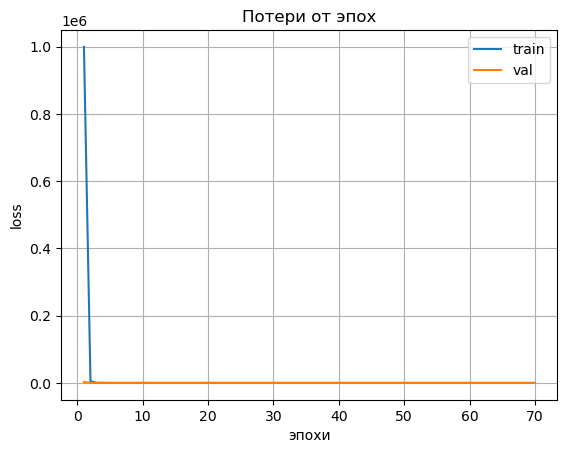

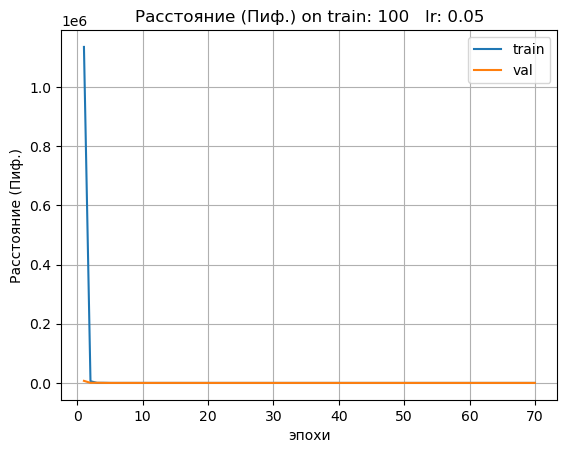

In [60]:
model = Net(params)

loss_fn = nn.SmoothL1Loss(reduction = 'sum')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min',factor = 0.5, patience = 15, verbose = 1)

train_dataloader = DataLoader(
    dataset = EYE_Dataset_update(
        mode = 'train',
        transform_function = transformer,
        params_transform_dict = transform_params_train),
    batch_size = 256,
    shuffle = False
)


val_dataloader = DataLoader(
    dataset = EYE_Dataset_update(
        mode = 'val',
        transform_function = transformer,
        params_transform_dict = transform_params_val),
    batch_size = 256,
    shuffle = False
)


model, loss_history, metric_history = training_loop(

    name_model_folder = 'model_5',
    epoches = 100,
    model = model,
    optimizer = optimizer,
    metric_str = 'Расстояние (Пиф.)',
    scheduler_append = False,
    scheduler = scheduler,
    step_on = 'val_loss',
    loss_fn = loss_fn,
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer_append = False,
    reg_type = None,
    stop_mode = True,
    each__X__epoch = 10,
    min_delta = 0.0001,
    patience = 7, 
    verbose_epoch = 1

)


# model_6

## transformer update (no random shift)

In [61]:
def transformer_update(full_path_image, params):
    ''' 
    возвращает тензор трасформированного изображения
    '''
    image, label = resize_img_label(full_path_image, params["target_size"])
    if random.random() < params["p_hflip"]:
        image, label = random_hflip(image, label)
    if random.random() < params["p_vflip"]:
        image, label = random_vflip(image, label)
    if random.random() < params["p_shift"]:
        image, label = random_shift(image, label, params["max_translate"])
    if random.random() < params["p_brightness"]:
        brightness_factor=1+(np.random.rand()*2-1)*params["brightness_factor"]
        image = TF.adjust_brightness(image,brightness_factor)
    if random.random() < params["p_contrast"]:
        contrast_factor=1+(np.random.rand()*2-1)*params["contrast_factor"]
        image=TF.adjust_contrast(image,contrast_factor)
    if random.random() < params["p_gamma"]:
        gamma=1+(np.random.rand()*2-1)*params["gamma"]
        image=TF.adjust_gamma(image,gamma)
    if params["scale_label"]:
        label = scale_label(label, params["target_size"])

    image = TF.to_tensor(image)
    return image, label


Размер тренировочного сета: 320
Размер валидационного сета: 80
Расчетное время выполнения всего цикла 31.735 минут
Epoch     1/  100 || time: 19.041 || train loss: 375.998 || val_loss: 2.420 || train metric: 564.775 || val metric: 49.035
Epoch     2/  100 || time: 17.984 || train loss: 9.098 || val_loss: 13.211 || train metric: 74.279 || val metric: 145.756
Epoch     3/  100 || time: 17.892 || train loss: 25.661 || val_loss: 13.010 || train metric: 140.869 || val metric: 144.654
Epoch     4/  100 || time: 17.353 || train loss: 24.216 || val_loss: 11.619 || train metric: 137.009 || val metric: 136.778
Epoch     5/  100 || time: 17.000 || train loss: 21.664 || val_loss: 9.965 || train metric: 128.438 || val metric: 126.711
Epoch     6/  100 || time: 17.096 || train loss: 19.107 || val_loss: 8.224 || train metric: 120.709 || val metric: 115.069
Epoch     7/  100 || time: 17.144 || train loss: 15.709 || val_loss: 6.433 || train metric: 108.518 || val metric: 101.536
Epoch     8/  100 || ti

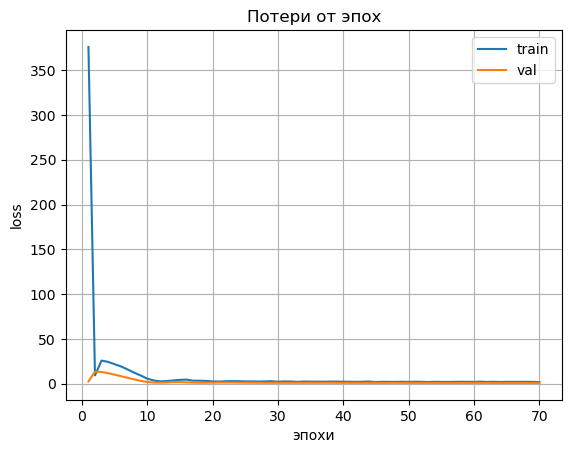

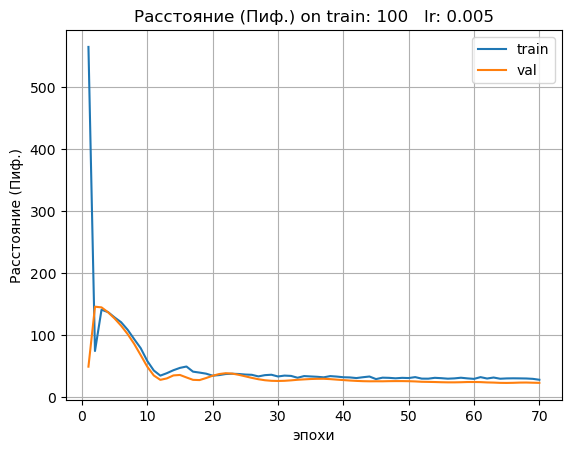

In [138]:
model = Net(params)

loss_fn = nn.SmoothL1Loss(reduction = 'sum')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min',factor = 0.5, patience = 15, verbose = 1)

train_dataloader = DataLoader(
    dataset = EYE_Dataset_update(
        mode = 'train',
        transform_function = transformer,
        params_transform_dict = transform_params_train),
    batch_size = 256,
    shuffle = False
)

val_dataloader = DataLoader(
    dataset = EYE_Dataset_update(
        mode = 'val',
        transform_function = transformer,
        params_transform_dict = transform_params_val),
    batch_size = 256,
    shuffle = False
)


model, loss_history, metric_history = training_loop(

    name_model_folder = 'model_6',
    epoches = 100,
    model = model,
    optimizer = optimizer,
    metric_str = 'Расстояние (Пиф.)',
    scheduler_append = False,
    scheduler = scheduler,
    step_on = 'val_loss',
    loss_fn = loss_fn,
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer_append = False,
    reg_type = None,
    stop_mode = True,
    each__X__epoch = 10,
    min_delta = 0.0001,
    patience = 7, 
    verbose_epoch = 1

)


# Evaluation

## Загрузка наилучших весов

In [140]:
model.load_state_dict(torch.load('model_6/model_weights_64_epoch.pth'))

<All keys matched successfully>

## Тестировочный датасет

In [141]:
class EYE_Dataset_for_testing(Dataset):
    
    def __init__(self,transform_function, params_transform_dict):
        
        dataframe = pd.read_excel(path2labels, index_col = 'ID')
        self.data = dataframe.sample(frac = 1, ignore_index = True, random_state = 42)

        path_to_AMD = 'Training400/AMD/'
        path_to_Non_AMD = 'Training400/Non-AMD/'

        self.paths = []
        for base_path in self.data['imgName']:
            if base_path[0] == 'A':
                self.paths.append(path_to_AMD + base_path)
            else:
                self.paths.append(path_to_Non_AMD + base_path)

        self.data['path'] = self.paths
        test_size = int(len(self.data) * 0.33)

        self.data = self.data[:test_size]
        self.frame = self.data[['Fovea_X', 'Fovea_Y']].values
        self.paths = self.data['path'].values
        print('Размер тестировочного сета: {}'.format(len(self.frame)))

        self.transforme_function = transform_function
        self.params_dict = params_transform_dict


    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        label = self.frame[index]
        image , label = self.transforme_function(self.paths[index], self.params_dict)
        return image, label, self.data.iloc[index]['path']

In [161]:
test_dataloader = DataLoader(
    dataset = EYE_Dataset_for_testing(
        transform_function = transformer_update,
        params_transform_dict = transform_params_train
    ),
    batch_size = 16,
    shuffle = False
)

test_frame = {
    'test_tensor':[],
    'test_labels':[],
    'path':[],
    'model_outputs':[]
}
for images, labels, dop_info in test_dataloader:
    test_frame['test_tensor'] = images
    test_frame['test_labels'] = labels
    test_frame['path'] = dop_info
    break

Размер тестировочного сета: 132


In [162]:
test_outputs = model(test_frame['test_tensor'].to(device))
test_outputs

tensor([[0.4973, 0.4968],
        [0.5159, 0.5186],
        [0.5077, 0.5074],
        [0.5217, 0.5235],
        [0.4840, 0.4811],
        [0.4776, 0.4743],
        [0.4673, 0.4607],
        [0.4797, 0.4755],
        [0.4446, 0.4343],
        [0.4495, 0.4403],
        [0.4746, 0.4688],
        [0.5462, 0.5503],
        [0.5210, 0.5234],
        [0.4610, 0.4556],
        [0.4619, 0.4547],
        [0.4962, 0.4951]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [163]:
test_frame['model_outputs'] = test_outputs
test_frame['test_labels'] = torch.hstack([test_frame['test_labels'][0].reshape(-1,1), test_frame['test_labels'][1].reshape(-1,1)])

## функции для рисовки тестовых результатов

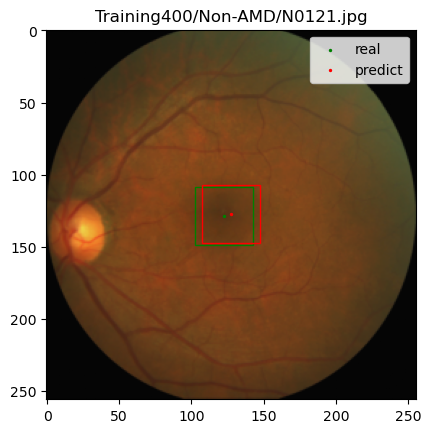

In [279]:
def draw_square(x, y, side_length, color):
    ax = plt.subplot()
    square = patches.Rectangle((x - side_length / 2, y - side_length / 2), side_length, side_length, edgecolor = color, facecolor='none')
    ax.add_patch(square)
    ax.set_aspect('equal')


def plot_testing_results(index_of_picture):
    x , y =\
    rescale_label((test_frame['test_labels'][index_of_picture][0], test_frame['test_labels'][index_of_picture][1]), image_size = (256,256))
    x = x.item()
    y = y.item()

    x_predict, y_predict =\
    rescale_label((test_frame['model_outputs'][index_of_picture][0], test_frame['model_outputs'][index_of_picture][1]), image_size = (256,256))
    x_predict = x_predict.item()
    y_predict = y_predict.item()

    plt.imshow(test_frame['test_tensor'][index_of_picture].permute(1,2,0).cpu().numpy())
    plt.scatter(x, y, color = 'green',s = 2, label = 'real')
    plt.scatter(x_predict, y_predict, s = 2, color = 'red', label = 'predict')
    plt.legend()
    # пример использования
    draw_square(x, y, 40, 'green')
    draw_square(x_predict , y_predict, 40, 'red')
    plt.title(test_frame['path'][index_of_picture])
    plt.show()


plot_testing_results(0)


# Визуализация результатов

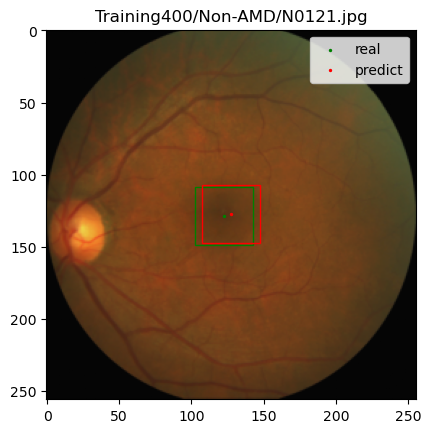

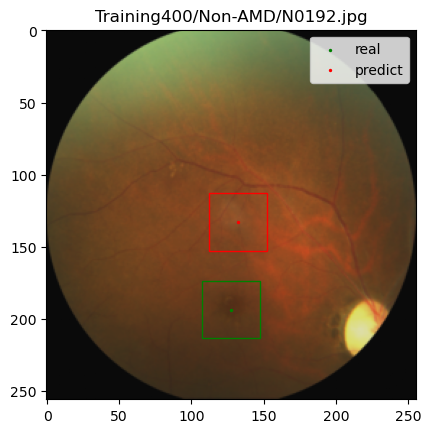

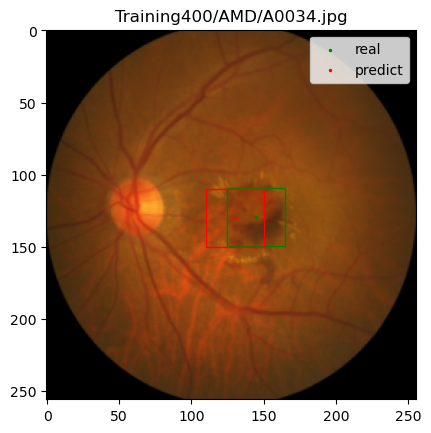

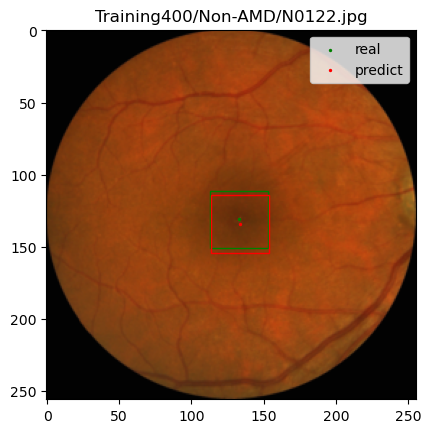

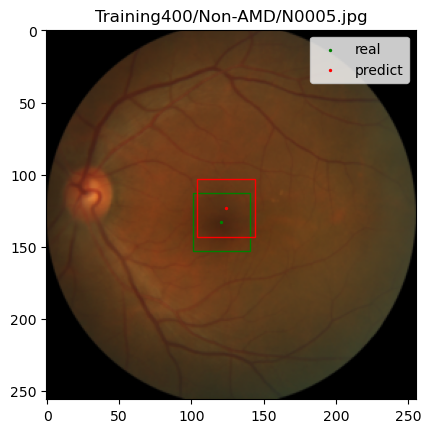

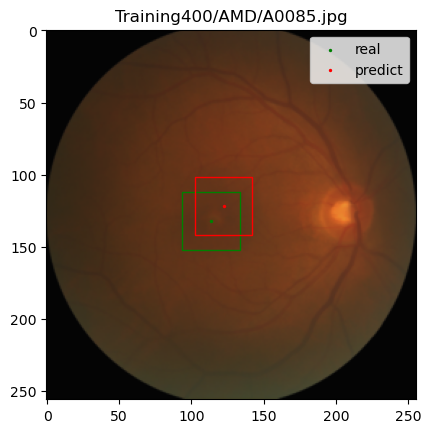

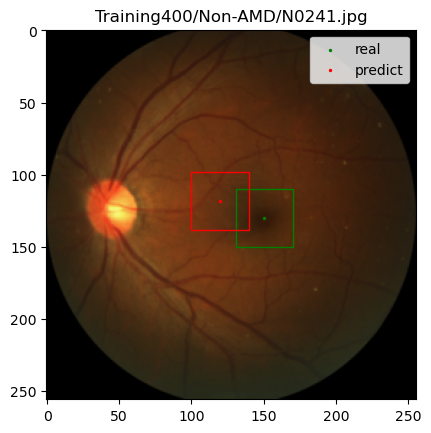

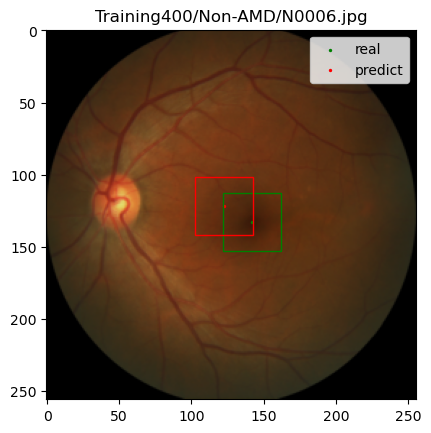

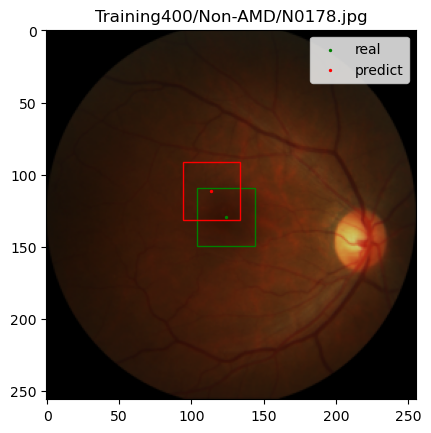

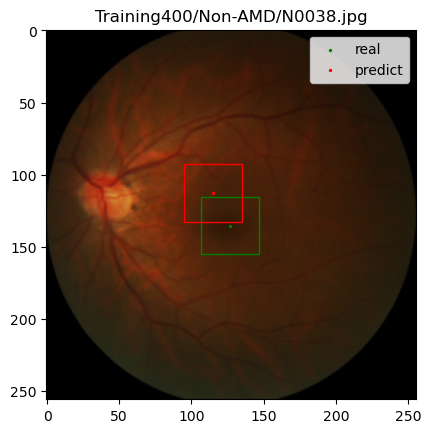

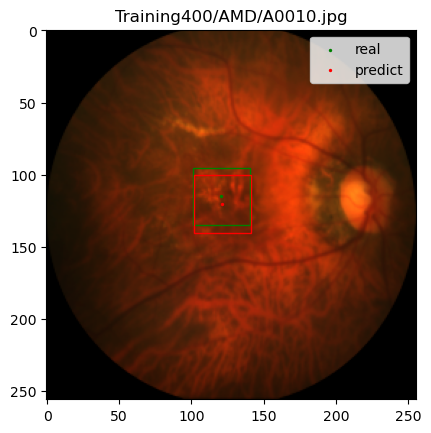

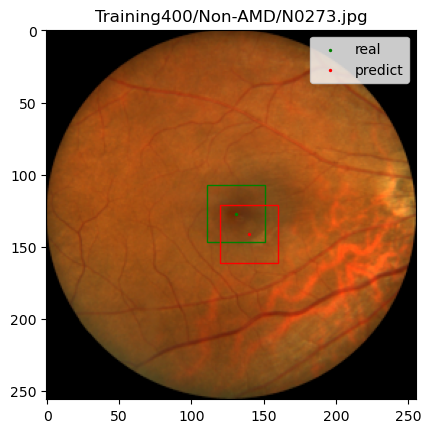

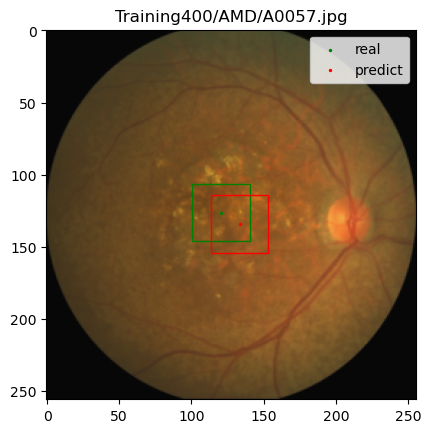

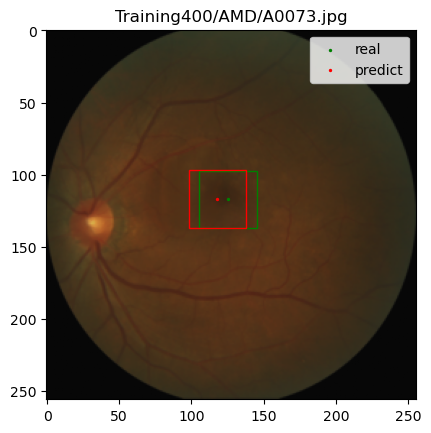

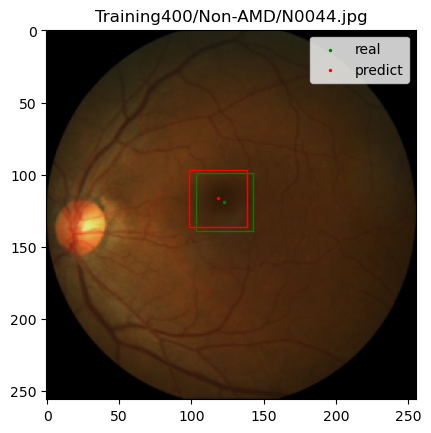

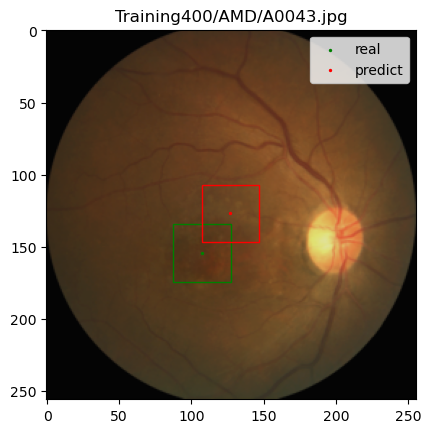

In [280]:
for i in range(16):
    plot_testing_results(i)

# Вывод

результаты лучшей модели:

train loss: 1.775 || val_loss: 0.734 || train pifagor: 29.561 || val pifagor: 22.905
